In [35]:

import re
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer


TRAIN_CSV = "/Users/sayedmahdi/Desktop/MyFolder/Practice/self_practicing/ML/synthetic_data_320.csv"
TEST_XLSX = "/Users/sayedmahdi/Desktop/MyFolder/Practice/self_practicing/ML/Book1.xlsx"
RANDOM_STATE = 42
SAVE_BEST_TO = Path("best_rf_grid.joblib")  
SAVE_CV_CSV  = Path("gridsearch_results.csv")

TARGET_RENAME = {
    "SAI 7d":  "Compressive strength (psi) 7d",
    "SAI 28d": "Compressive strength (psi) 28d",
    "SAI 56d": "Compressive strength (psi) 56d",
    "SAI 90d": "Compressive strength (psi) 90d",
}
TARGET_COLS = list(TARGET_RENAME.values())


try:
    from sklearn.metrics import root_mean_squared_error as _rmse_fn 
    def RMSE(y_true, y_pred): return _rmse_fn(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error as _mse
    def RMSE(y_true, y_pred): return _mse(y_true, y_pred, squared=False)
rmse_scorer = make_scorer(lambda yt, yp: -RMSE(yt, yp)) 

def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [re.sub(r'\s+', ' ', str(c).replace('%', '')).strip() for c in df.columns]
    return df.loc[:, ~df.columns.duplicated()]

def _strip_percent_values(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == 'object' and df[c].astype(str).str.contains('%').any():
            df[c] = (df[c].astype(str)
                           .str.replace(r'[^0-9.\-eE]', '', regex=True)
                           .replace({'': np.nan})
                           .astype(float))
    return df


df_train = pd.read_csv(TRAIN_CSV).rename(columns=TARGET_RENAME)
df_test  = pd.read_excel(TEST_XLSX).rename(columns=TARGET_RENAME)

df_train = _strip_percent_values(_clean_cols(df_train))
df_test  = _strip_percent_values(_clean_cols(df_test))

missing_train = [c for c in TARGET_COLS if c not in df_train.columns]
missing_test  = [c for c in TARGET_COLS if c not in df_test.columns]
if missing_train: raise ValueError(f"Train missing targets: {missing_train}")
if missing_test:  raise ValueError(f"Test missing targets: {missing_test}")

X_train_full, y_train = df_train.drop(columns=TARGET_COLS), df_train[TARGET_COLS].copy()
X_test_full,  y_test  = df_test.drop(columns=TARGET_COLS),  df_test[TARGET_COLS].copy()

# Align shared features (order = train)
shared = [c for c in X_train_full.columns if c in X_test_full.columns]
if not shared: raise ValueError("No shared feature columns between train and test.")
X_train, X_test = X_train_full[shared].copy(), X_test_full[shared].copy()


is_obj = X_train.dtypes == "object"
is_cat = X_train.dtypes.astype(str) == "category"
cat_cols = X_train.columns[is_obj | is_cat].tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

try:
    ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])

transformers = [("num", num_pipe, num_cols)]
if cat_cols: transformers.append(("cat", cat_pipe, cat_cols))
preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")


rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
pipe = Pipeline([("prep", preprocessor), ("model", rf)])

param_grid = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [None, 12, 16],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.75],
    "model__bootstrap": [True],
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={"r2": "r2", "rmse": rmse_scorer},
    refit="r2",            
    cv=5,                  
    n_jobs=-1,
    verbose=1,
    error_score="raise"
)


gs.fit(X_train, y_train)


print("\n=== Best Hyperparameters (by CV R²) ===")
for k, v in gs.best_params_.items():
    print(f"{k}: {v}")

print(f"\nBest CV R²:  {gs.best_score_:.6f}")
best_idx = gs.best_index_
best_cv_rmse = -gs.cv_results_["mean_test_rmse"][best_idx]
print(f"Best CV RMSE: {best_cv_rmse:.6f}")


cv_cols = [c for c in gs.cv_results_.keys() if c.startswith('param_') or c.startswith('mean_test_') or c.startswith('std_test_')]
cv_df = pd.DataFrame(gs.cv_results_)[cv_cols].sort_values("mean_test_r2", ascending=False)
cv_df.to_csv(SAVE_CV_CSV, index=False)
print(f"\nSaved full CV results to: {SAVE_CV_CSV.resolve()}")
print("\nTop 10 CV rows:")
print(cv_df.head(10))


best_pipe = gs.best_estimator_

if SAVE_BEST_TO:
    import joblib
    joblib.dump(best_pipe, SAVE_BEST_TO)
    print(f"\nSaved best model to: {SAVE_BEST_TO.resolve()}")

y_pred = best_pipe.predict(X_test)

print("\n=== External Test Set Performance ===")
for i, col in enumerate(TARGET_COLS):
    r2   = r2_score(y_test.iloc[:, i], y_pred[:, i])
    rmse = RMSE(y_test.iloc[:, i], y_pred[:, i])
    mae  = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"{col}: R²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits

=== Best Hyperparameters (by CV R²) ===
model__bootstrap: True
model__max_depth: None
model__max_features: 0.75
model__min_samples_leaf: 1
model__min_samples_split: 2
model__n_estimators: 300

Best CV R²:  0.992192
Best CV RMSE: 56.840856

Saved full CV results to: /Users/sayedmahdi/self_learning/gridsearch_results.csv

Top 10 CV rows:
    param_model__bootstrap param_model__max_depth param_model__max_features  \
25                    True                   None                      0.75   
97                    True                     16                      0.75   
61                    True                     12                      0.75   
27                    True                   None                      0.75   
99                    True                     16                      0.75   
63                    True                     12                      0.75   
24                    True                   

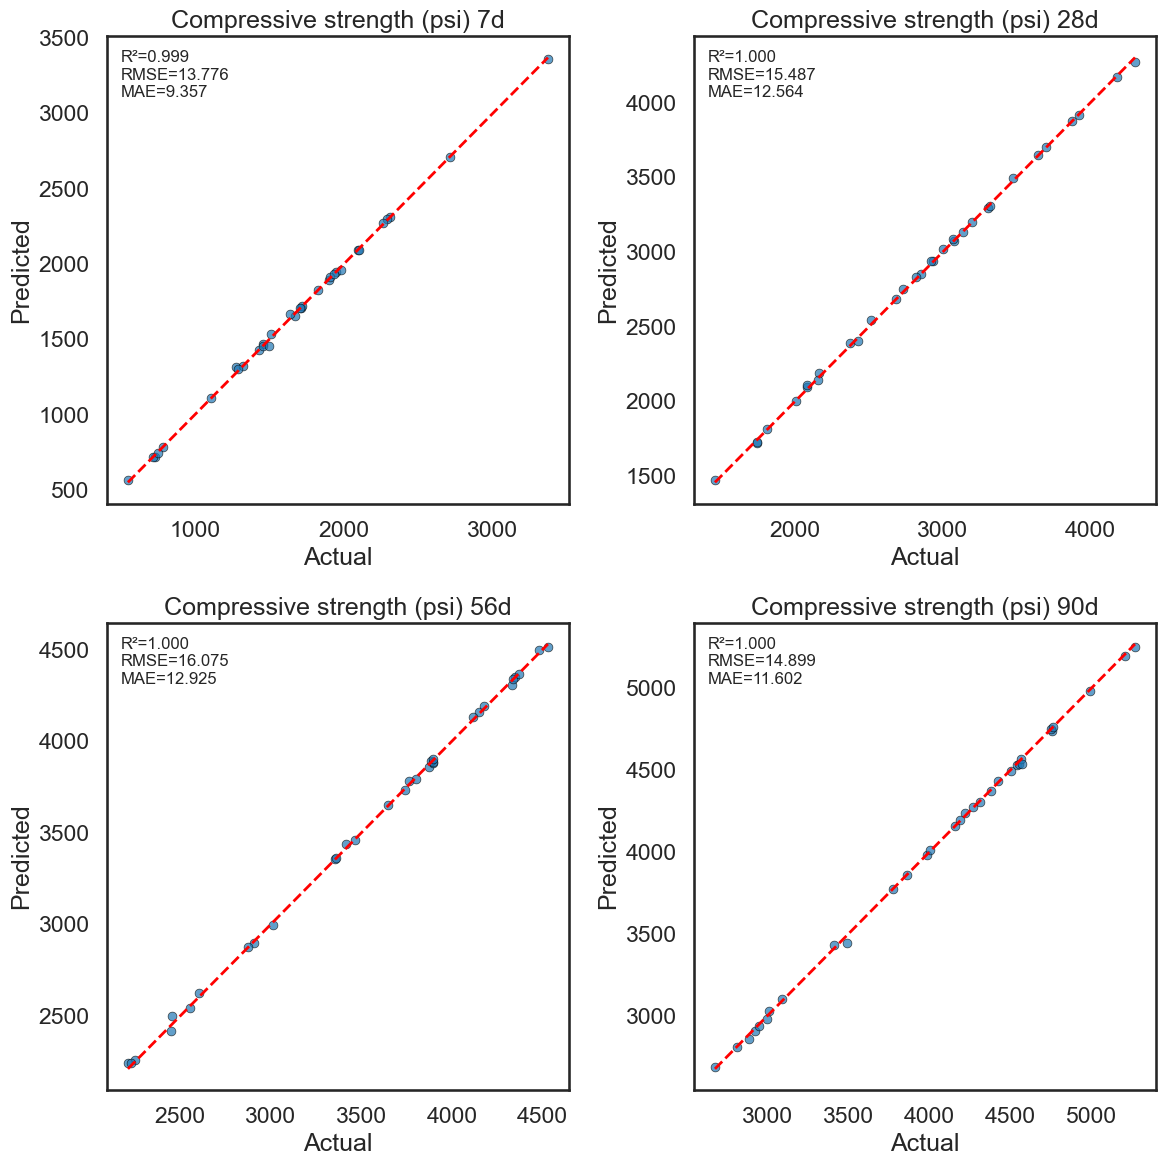

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

def _plot_actual_vs_pred(ax, actual, pred, title):
    ax.scatter(actual, pred, s=40, edgecolor="k", linewidth=0.5, alpha=0.7)
    lo = min(np.min(actual), np.min(pred))
    hi = max(np.max(actual), np.max(pred))
    ax.plot([lo, hi], [lo, hi], linestyle="--", color="red", lw=2)
    r2   = r2_score(actual, pred)
    rmse = RMSE(actual, pred)
    mae  = mean_absolute_error(actual, pred)
    ax.text(0.03, 0.97,
            f"R²={r2:.3f}\nRMSE={rmse:.3f}\nMAE={mae:.3f}",
            ha="left", va="top", transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i, col in enumerate(TARGET_COLS):
    _plot_actual_vs_pred(axes[i], y_test.iloc[:, i], y_pred[:, i], col)

plt.tight_layout()
plt.show()


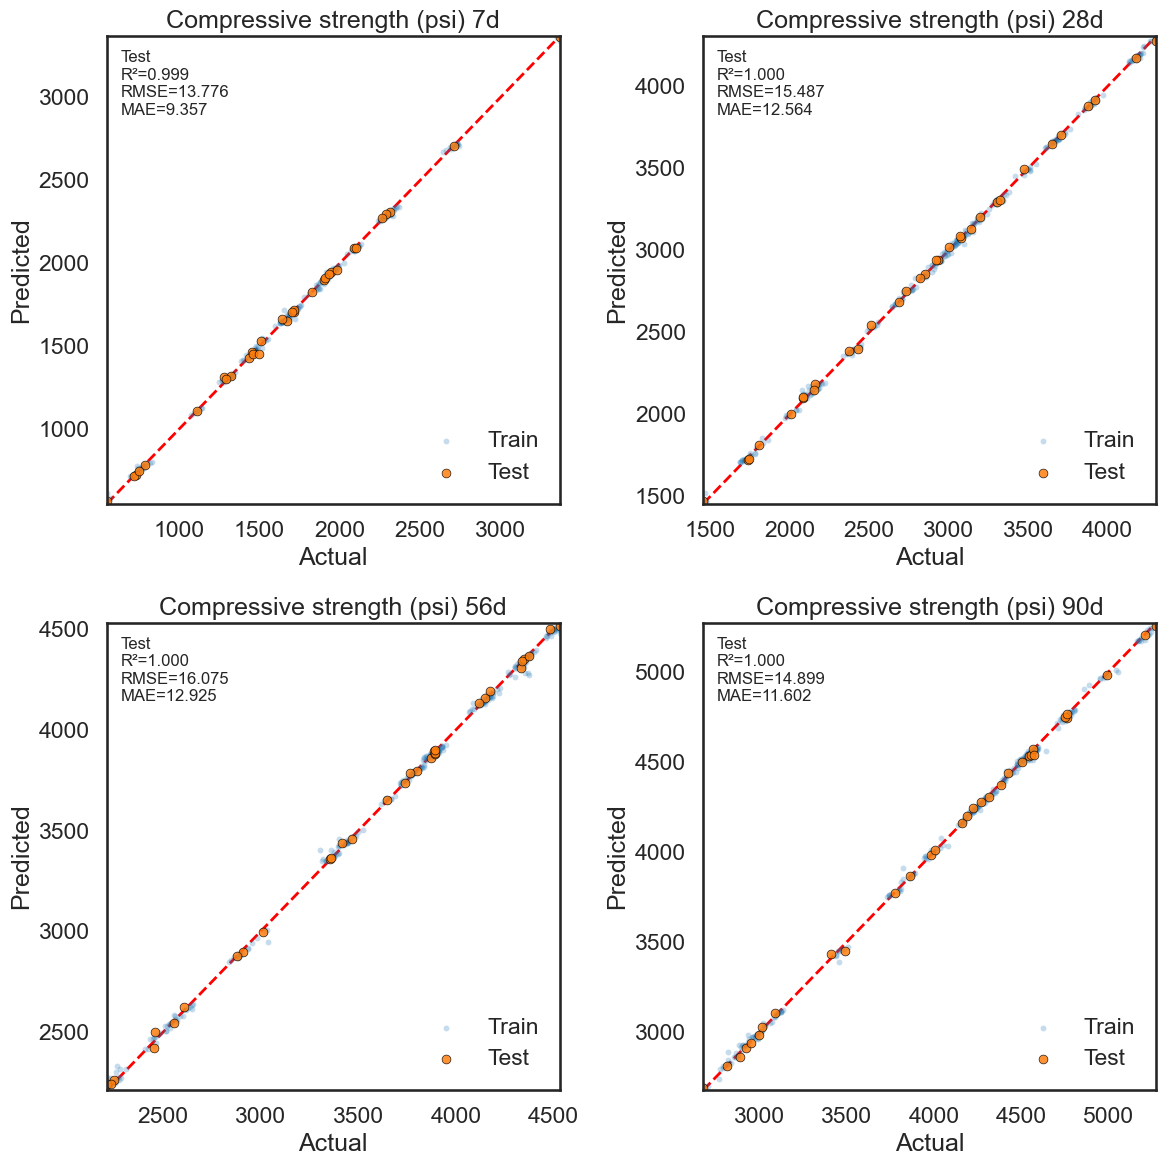

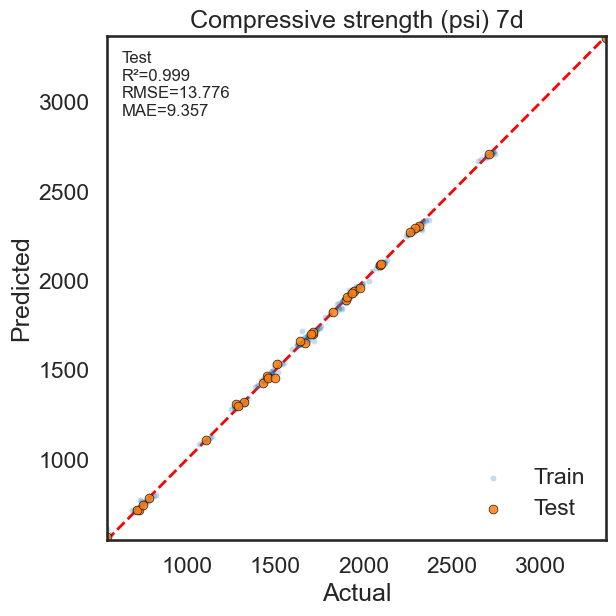

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")


y_train_pred = best_pipe.predict(X_train)

def _plot_avp_with_train(ax, actual_train, pred_train, actual_test, pred_test, title):

    lo = float(min(np.min(actual_train), np.min(pred_train), np.min(actual_test), np.min(pred_test)))
    hi = float(max(np.max(actual_train), np.max(pred_train), np.max(actual_test), np.max(pred_test)))

    # training points (lighter & smaller, underlaid)
    ax.scatter(actual_train, pred_train,
               s=18, alpha=0.25, linewidth=0, label="Train", zorder=1)


    ax.scatter(actual_test, pred_test,
               s=40, edgecolor="k", linewidth=0.5, alpha=0.85, label="Test", zorder=2)


    ax.plot([lo, hi], [lo, hi], linestyle="--", color="red", lw=2, zorder=0)

    # metrics (computed on TEST for honest evaluation)
    r2   = r2_score(actual_test, pred_test)
    rmse = RMSE(actual_test, pred_test)
    mae  = mean_absolute_error(actual_test, pred_test)
    ax.text(0.03, 0.97,
            f"Test\nR²={r2:.3f}\nRMSE={rmse:.3f}\nMAE={mae:.3f}",
            ha="left", va="top", transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.legend(frameon=False, loc="lower right")
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
for i, col in enumerate(TARGET_COLS):
    _plot_avp_with_train(
        axes[i],
        y_train.iloc[:, i].to_numpy(), y_train_pred[:, i],
        y_test.iloc[:, i].to_numpy(),  y_pred[:, i],
        title=col
    )
plt.tight_layout()
plt.show()

try:
    idx_7d = TARGET_COLS.index("Compressive strength (psi) 7d")
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    _plot_avp_with_train(
        ax,
        y_train.iloc[:, idx_7d].to_numpy(), y_train_pred[:, idx_7d],
        y_test.iloc[:, idx_7d].to_numpy(),  y_pred[:, idx_7d],
        title="Compressive strength (psi) 7d"
    )
    plt.tight_layout()
    plt.show()
except ValueError:

    pass



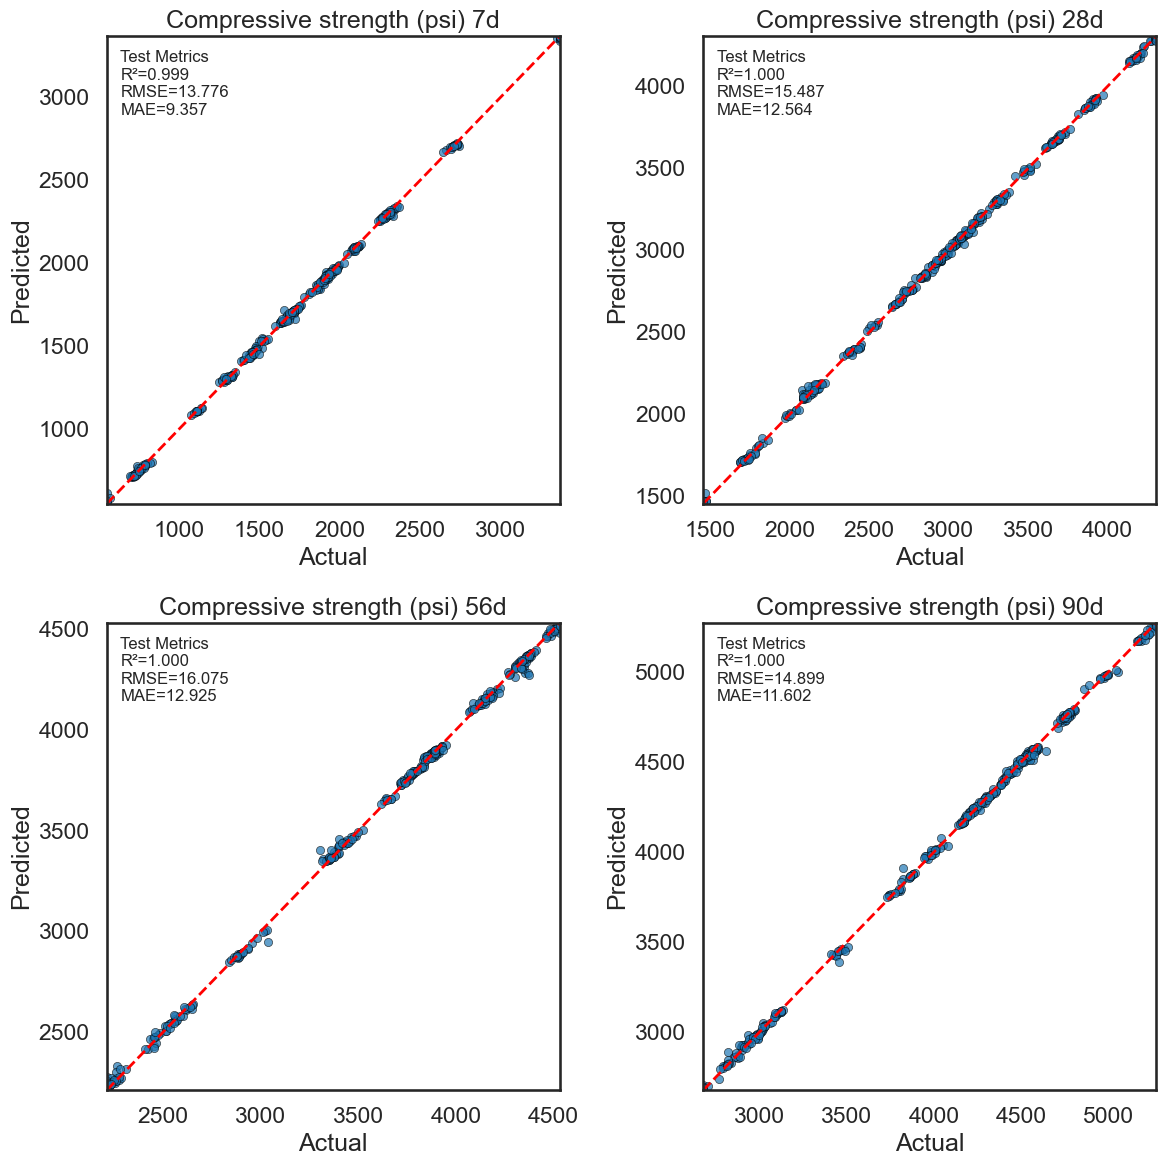

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")


y_train_pred = best_pipe.predict(X_train)
y_test_pred  = best_pipe.predict(X_test)


y_all_true = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
y_all_pred = np.vstack([y_train_pred, y_test_pred])

def _plot_avp(ax, actual, pred, title):
    lo = float(min(np.min(actual), np.min(pred)))
    hi = float(max(np.max(actual), np.max(pred)))

    ax.scatter(actual, pred, s=35, alpha=0.7, edgecolor="k", linewidth=0.5)

    ax.plot([lo, hi], [lo, hi], linestyle="--", color="red", lw=2)

    # Metrics (still show TEST metrics for honesty)
    r2   = r2_score(y_test.iloc[:, TARGET_COLS.index(title)], y_test_pred[:, TARGET_COLS.index(title)])
    rmse = RMSE(y_test.iloc[:, TARGET_COLS.index(title)], y_test_pred[:, TARGET_COLS.index(title)])
    mae  = mean_absolute_error(y_test.iloc[:, TARGET_COLS.index(title)], y_test_pred[:, TARGET_COLS.index(title)])
    ax.text(0.03, 0.97,
            f"Test Metrics\nR²={r2:.3f}\nRMSE={rmse:.3f}\nMAE={mae:.3f}",
            ha="left", va="top", transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

    ax.set_title(title)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()
for i, col in enumerate(TARGET_COLS):
    _plot_avp(axes[i], y_all_true.iloc[:, i], y_all_pred[:, i], col)

plt.tight_layout()
plt.show()


In [39]:
import os
out_dir = "avp_plots"
os.makedirs(out_dir, exist_ok=True)

for i, col in enumerate(TARGET_COLS):
    fig, ax = plt.subplots(figsize=(5, 5))  
    
    actual = y_all_true.iloc[:, i]
    pred   = y_all_pred[:, i]

    lo = float(min(np.min(actual), np.min(pred)))
    hi = float(max(np.max(actual), np.max(pred)))


    ax.scatter(actual, pred, s=35, alpha=0.7, edgecolor="k", linewidth=0.5)

  
    ax.plot([lo, hi], [lo, hi], linestyle="--", color="red", lw=2)

    r2   = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    rmse = RMSE(y_test.iloc[:, i], y_test_pred[:, i])
    mae  = mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
    ax.text(0.03, 0.97,
            f"R²={r2:.3f}\nRMSE={rmse:.3f}\nMAE={mae:.3f}",
            ha="left", va="top", transform=ax.transAxes,
            fontsize=11, bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))


    ax.set_xlabel("Actual Compressive strength (psi)", fontsize=14)
    ax.set_ylabel("Predicted Compressive strength (psi)", fontsize=14)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    plt.tight_layout()

 
    safe_name = col.replace(" ", "_").replace("/", "-")
    fig.savefig(os.path.join(out_dir, f"avp_{safe_name}_5x5.png"),
                dpi=200, bbox_inches="tight")
    plt.close(fig)   

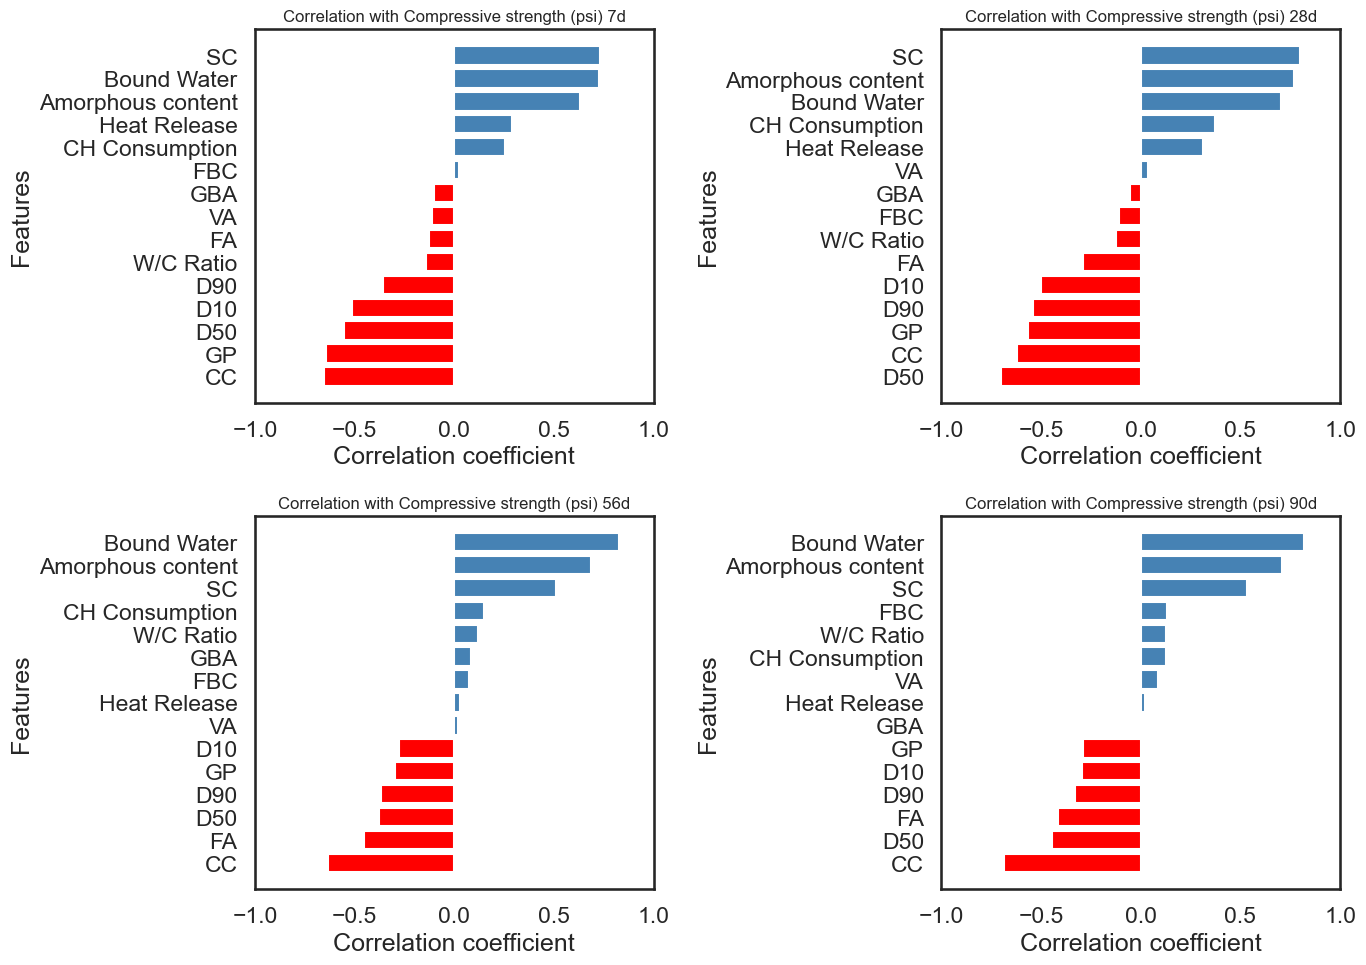

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
corrs = df_train.corr(numeric_only=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(TARGET_COLS):
    ax = axes[i]
    
    # correlation with current target
    corr_target = corrs[col].drop(TARGET_COLS)  
    corr_target = corr_target.sort_values()    

    colors = ["red" if v < 0 else "steelblue" for v in corr_target]

    ax.barh(corr_target.index, corr_target.values, color=colors)
    ax.set_title(f"Correlation with {col}", fontsize=12)
    ax.set_xlabel("Correlation coefficient")
    ax.set_ylabel("Features")
    ax.set_xlim(-1, 1)

plt.tight_layout()
out_dir = "correlation_plots"
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, "feature_correlations.png"),
            dpi=300, bbox_inches="tight")

plt.show()


In [48]:
import matplotlib.pyplot as plt
import os
out_dir = "correlation_plots"
os.makedirs(out_dir, exist_ok=True)
corrs = df_train.corr(numeric_only=True)

for i, col in enumerate(TARGET_COLS):
    fig, ax = plt.subplots(figsize=(7, 5))
    corr_target = corrs[col].drop(TARGET_COLS)  
    corr_target = corr_target.sort_values()      
    colors = ["red" if v < 0 else "steelblue" for v in corr_target]
    ax.barh(corr_target.index, corr_target.values, color=colors)

    ax.set_xlabel("Correlation coefficient")
    ax.set_ylabel("Features")
    ax.set_xlim(-1, 1)

    plt.tight_layout()

    safe_name = col.replace(" ", "_").replace("/", "-")
    fig.savefig(os.path.join(out_dir, f"corr_{safe_name}.png"),
                dpi=300, bbox_inches="tight")
    plt.close(fig) 


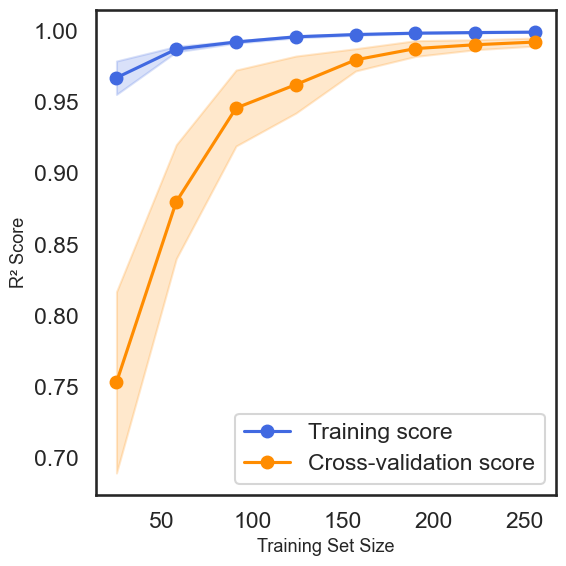

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve



train_sizes, train_scores, val_scores = learning_curve(
    best_pipe,
    X_train, y_train,
    cv=5,
    scoring="r2",      
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8), 
    shuffle=True,
    random_state=42
)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)


plt.figure(figsize=(6,6))
plt.plot(train_sizes, train_mean, "o-", color="royalblue", label="Training score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std,
                 alpha=0.2, color="royalblue")

plt.plot(train_sizes, val_mean, "o-", color="darkorange", label="Cross-validation score")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std,
                 alpha=0.2, color="darkorange")

plt.xlabel("Training Set Size", fontsize=13)
plt.ylabel("R² Score", fontsize=13)

plt.legend(loc="best")
plt.grid(False)
plt.tight_layout()
plt.savefig("learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()


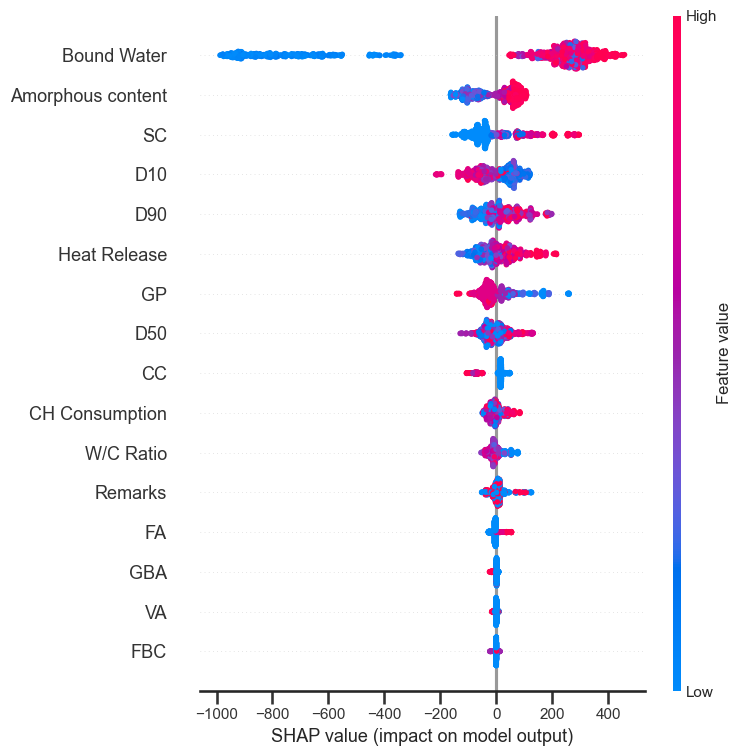

In [55]:
import shap
import numpy as np
import matplotlib.pyplot as plt
def get_transformed_feature_names(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'get_feature_names_out'):

            try:

                last = trans
                if hasattr(trans, 'steps'):
                    last = trans.steps[-1][1]
                if hasattr(last, 'get_feature_names_out'):
                    ohe_names = last.get_feature_names_out(cols)
                    names.extend(ohe_names.tolist())
                else:
                    names.extend(list(cols))
            except Exception:
                names.extend(list(cols))
        else:
            names.extend(list(cols))
    return names

prep   = best_pipe.named_steps['prep']
model  = best_pipe.named_steps['model']


Xtr_trans = prep.transform(X_train)

feat_names = get_transformed_feature_names(prep)

if len(feat_names) != Xtr_trans.shape[1]:
    feat_names = [f"f{i}" for i in range(Xtr_trans.shape[1])]

explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(Xtr_trans)  

def _get_shap_for_output(shap_vals, k):
  
    if isinstance(shap_vals, list):
        return shap_vals[k]
    sval = np.asarray(shap_vals)
    if sval.ndim == 3 and sval.shape[-1] == len(TARGET_COLS):
        return sval[:, :, k]

    return sval

for k, tgt in enumerate(TARGET_COLS):
    shap_k = _get_shap_for_output(shap_vals, k)

    plt.figure(figsize=(5, 5)) 
    shap.summary_plot(
        shap_values=shap_k,
        features=Xtr_trans,
        feature_names=feat_names,
        plot_type="dot",
        show=False, 
        max_display=30 
    )
    # Remove title if SHAP adds any (it usually doesn't for beeswarm)
    ax = plt.gca()
    ax.set_title("")  # ensure no title
    # Clean axis labels (SHAP doesn’t set x/y labels; we’ll add an x-label)
    plt.xlabel("SHAP value (impact on model output)")
    plt.tight_layout()
    plt.show()

for k, tgt in enumerate(TARGET_COLS):
    shap_k = _get_shap_for_output(shap_vals, k)
    mean_abs = np.abs(shap_k).mean(axis=0)
    order = np.argsort(mean_abs)[::-1][:30]  # top-30

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.barh([feat_names[i] for i in order][::-1], mean_abs[order][::-1])
    ax.set_xlabel("Mean |SHAP|")
    ax.set_ylabel("Features")
    plt.tight_layout()
    # plt.show()   # uncomment if you want this figure as well


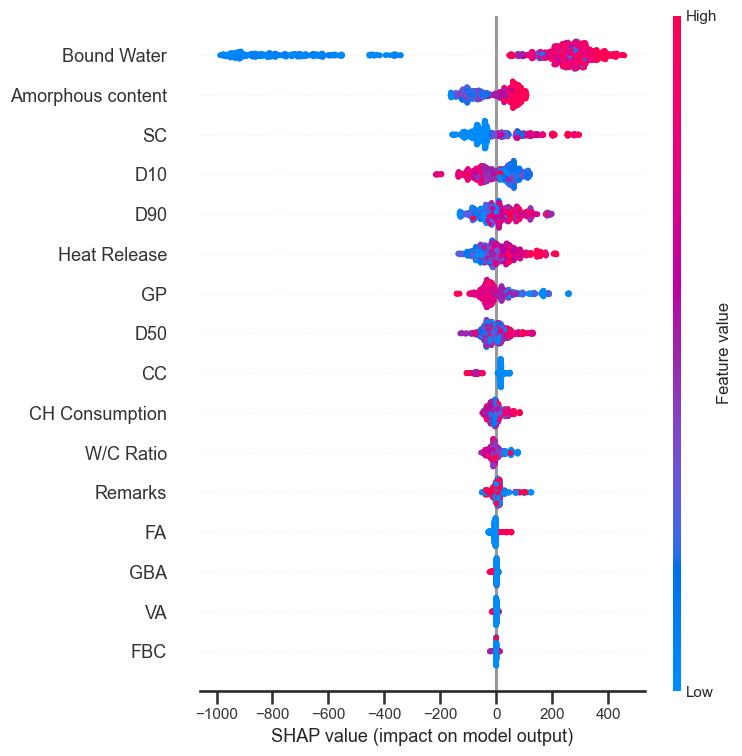

In [59]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import shap

def get_transformed_feature_names(preprocessor):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        last = trans
        if hasattr(trans, "steps"):
            last = trans.steps[-1][1]
        if hasattr(last, "get_feature_names_out"):
            try:
                got = last.get_feature_names_out(cols)
                names.extend(got.tolist())
            except Exception:
                names.extend(list(cols))
        else:
            names.extend(list(cols))
    return names

def prettify_feature_labels(labels):
    pretty = []
    for s in labels:
        t = str(s)
        t = re.sub(r'^(ohe__|num__|cat__|prep__|model__)+', '', t)
        t = re.sub(r'(?i)^remarks_plc', 'Remarks', t)
        t = re.sub(r'(?i)_remarks_plc', '_remarks', t)
        t = re.sub(r'__+', '_', t).strip('_')
        pretty.append(t)
    return pretty

prep  = best_pipe.named_steps["prep"]
model = best_pipe.named_steps["model"]

Xtr_trans = prep.transform(X_train)
feat_names = get_transformed_feature_names(prep)
if len(feat_names) != Xtr_trans.shape[1]:
    feat_names = [f"f{i}" for i in range(Xtr_trans.shape[1])]

feat_names_pretty = prettify_feature_labels(feat_names)

explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(Xtr_trans)

if isinstance(shap_vals, list):
    shap_list = shap_vals
else:
    arr = np.asarray(shap_vals)
    if arr.ndim == 2:
        shap_list = [arr]
    elif arr.ndim == 3 and arr.shape[-1] == len(TARGET_COLS):
        shap_list = [arr[:, :, k] for k in range(len(TARGET_COLS))]
    else:
        raise ValueError(f"Unexpected SHAP shape: {arr.shape}")
shap_combined = np.vstack(shap_list)
X_combined    = np.vstack([Xtr_trans]*len(shap_list))

plt.figure(figsize=(5, 5))
shap.summary_plot(
    shap_values=shap_combined,
    features=X_combined,
    feature_names=feat_names_pretty,
    plot_type="dot",
    show=False,
    max_display=30
)
ax = plt.gca()
ax.set_title("")
plt.xlabel("SHAP value (impact on model output)")
plt.tight_layout()

out_dir = "shap_plots"
os.makedirs(out_dir, exist_ok=True)
plt.gcf().savefig(os.path.join(out_dir, "shap_beeswarm_combined.png"),
                  dpi=300, bbox_inches="tight")

plt.show()
